#### 2018/05/09

# CS236605: Deep Learning<br>Homework 1

### Aviv Rosenberg<br>avivr@cs.technion.ac.il

### Section 1

We have trained a ResNet18 and VGG16 model for 100 epochs with three optimizer configurations:
 - SGD, `learn_rate=0.1`, `momentum=0.9`
 - SGD without momentum, `learn_rate=0.1`
 - Adam, `learn_rate=0.1`
 
The output for both models in each configuration was serialized to JSON after all epochs were completed.
Both the training code (modified from the original version) and the results plotting code can be found [here](https://github.com/avivrosenberg/pytorch-cifar). The result files themselves can be found in the `results/s{1,2,3}` directories.

We will load the JSON files and plot the accuracy and loss over the train and test sets in each configuration.

In [1]:
%matplotlib inline

# Import functions for loading and plotting result files (see hw1_plots.py)
from hw1_plots import *

# Load the results for section1
data = load_data([
    'results/s1/out-adam.json',
    'results/s1/out-sgd-momentum.json',
    'results/s1/out-sgd-vanilla.json'
])

The results of the **ResNet18** model can be seen below.
The loss function seems to decay quickly in the first few epochs, indicating that the learning rate is adequate. Additionally we can see the gap between the trainig and test set is accuracy relatively low (less than 10%) so there is not too much overfitting. The Adam and Vanilla SGD seem to perform the best on both sets. It's possible that the momentum value is too large, causeing the SGD with momentum to miss the local minimum that the vanilla SGD finds in this case.

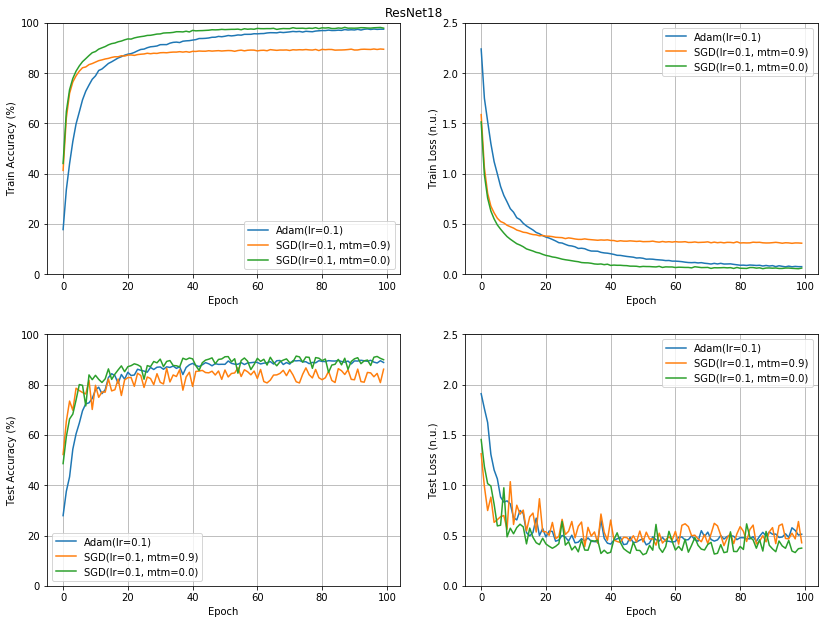

In [2]:
fig_resnet18 = plot_model_results(get_model_results(data, 'ResNet18'))

The plots for the  **VGG16** model can be seen below. Here we see a slightly different trend of the loss function between the different optimization algorithms. For Adam, the loss decreases quite slowly initially compared to SGD. This could indicate that a slighly larger learning rate could have been appropriate to speed up the convergence. As in the previous model, Vanilla SGD and Adam perform best.

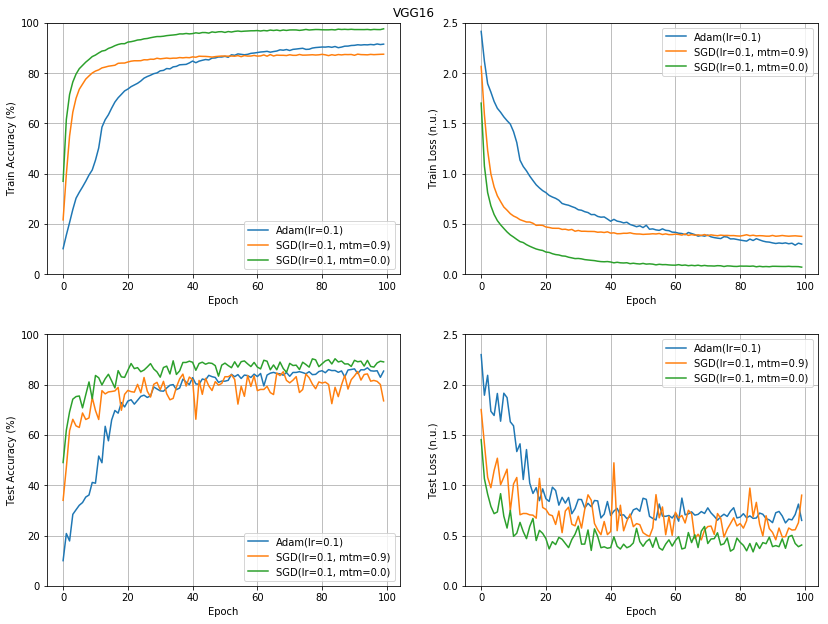

In [3]:
fig_resnet18 = plot_model_results(get_model_results(data, 'VGG16'))

### Section 2 - Fine Tuning

Here we ran both models using the SGD (with momentum) optimizer for 100 additional epochs. The results are displayed in the plots below.

Notice the start epoch is less than 100. This is due to the fact that the last saved model state was at an epoch before 100 during the original training since the test set accuracy didn't improve further after that epoch.

To improve the accuracy further we selected a learning rate which was ten time smaller. The rationale is that if the optimizer is close to a local minimum of the loss function it might keep "jumping over" the minimum due to a high learning rate. Starting from the baest saved model parameters and then optimizing further with a much smaller learning rate allows the model to converge to a point closer to the local minimum that we were previously jumping over.

The results indeed show that in the first few epochs with the smaller learning rate the training-set accuracies improve. However, when looking at the test set we see an opposite trend. This indicates that by getting closer to the local minima of the training set we have somewhat overfitted our model to it.

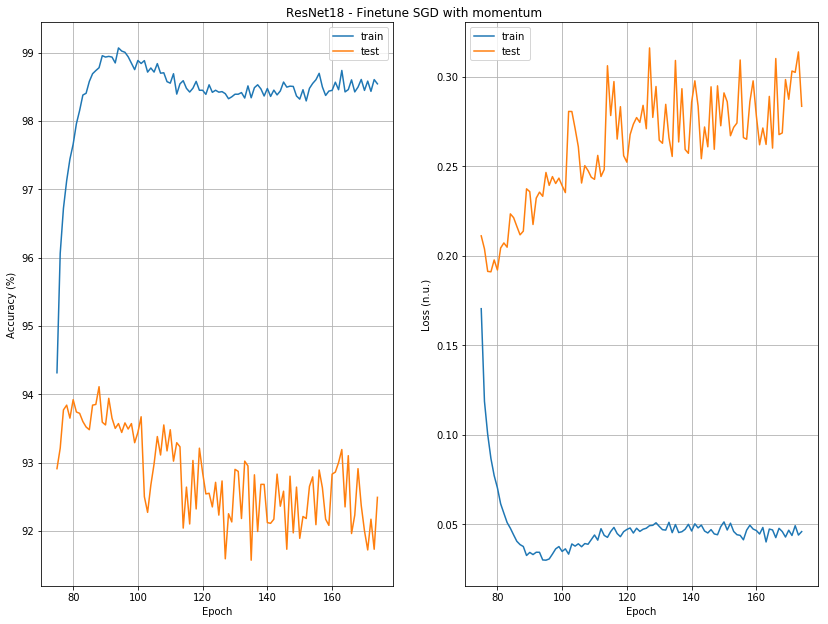

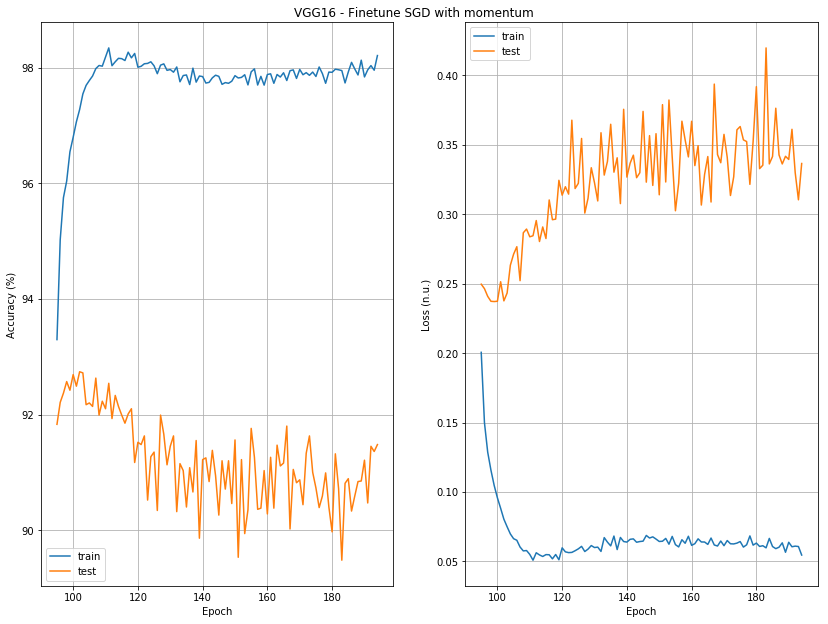

In [4]:
data_resumed = load_data([
    'results/s2/ResNet18-resume.json',
    'results/s2/VGG16-resume.json'
])

for model_name in ['ResNet18', 'VGG16']:
    fig = plot_finetune_results(get_model_results(data_resumed, model_name))

### Section 3 - No Batch Normalization

We have modified the ResNet18 and VGG16 models by removing all batch normalizations layers. We then proceeded to train the models for 100 epochs with the following optimizer configurations:
 - SGD, `learn_rate=0.1`, `momentum=0.9`
 - SGD without momentum, `learn_rate=0.1`
 - Adam, `learn_rate=0.001`
 
Batch Normalization normalizes the features between the convolutional or FC layers and the non-linearities by removing mean and setting unit variance. Then, it uses parameters (which are also trained) to replace the mean and variance. This reduces the dependency on the weight initialization and hyperparemeter selection. In other words, when using batch normalization we could be more careless about the learning rate and momentum of SGD. Without it, it's much harder to find a combination that would allow the model to converge.

The **VGG16** model failed to converge for both SGD configurations - Accuracy remains flat at 10% which is equivalent to a random guess since there are 10 classes in this dataset.
Using the Adam optimization algorithm, the model does converge when setting a much smaller learning rate (0.001 in this case), but doesn't converge for values 1-2 orders of magnitude greater (which worked before).
With SGD, attempting to decrease the learning rate didn't help, although possibly some combination of learning rate and momentum could cause the model to converge. We can see this because it does converge with Adam, so the problem is not related to the net architecture after the change but to the steps the optimizer is making.

The **ResNet18** model on the other hand manages to converge and even acheives comparable results compared to the version with Batch Normalization. This shows that the ResNet architecture is less suceptible to initialization and hyperparameter tuning. In a recent paper, [Shang et. al](https://research.fb.com/wp-content/uploads/2017/01/paper_expl_norm_on_deep_res_networks.pdf) show that in the initial layers of a ResNet (up to about 36) Batch Normalization makes a relatively small difference. Since here we're using a shallow ResNet, it might explain out immunity to Batch Normalization removal.

Plots are shown below.

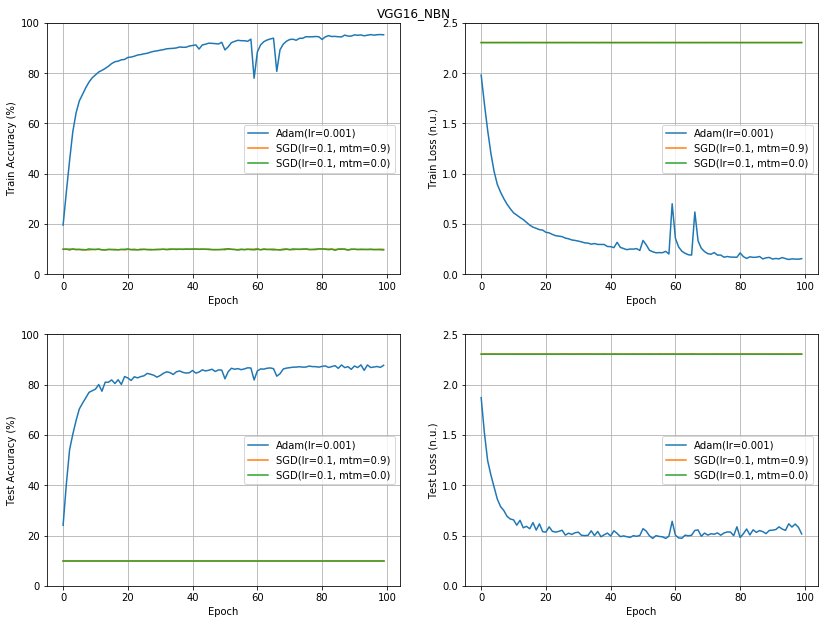

In [5]:
data_no_batchnorm = load_data([
    'results/s3/ResNet18_NBN-SGD_0.10_0.90.json',
    'results/s3/ResNet18_NBN-SGD_0.10_0.00.json',
    'results/s3/ResNet18_NBN-Adam_0.00_0.90.json', #lr=0.001
    'results/s3/VGG16_NBN-SGD_0.10_0.90.json',
    'results/s3/VGG16_NBN-SGD_0.10_0.00.json',
    'results/s3/VGG16_NBN-Adam_0.00_0.90.json',    #lr=0.001
])

fig = plot_model_results(get_model_results(data_no_batchnorm, 'VGG16_NBN'))

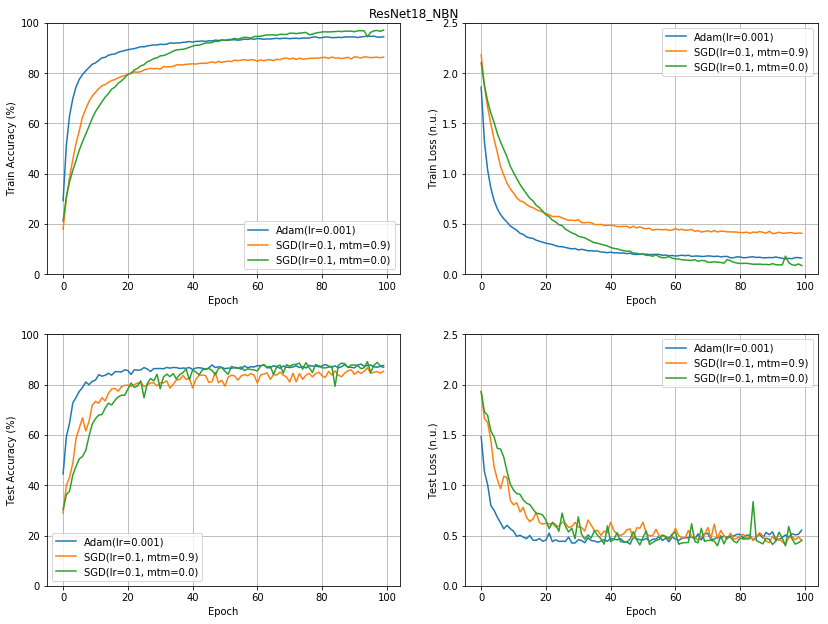

In [6]:
fig = plot_model_results(get_model_results(data_no_batchnorm, 'ResNet18_NBN'))